Here, we would like to implement a multivariate time series LSTM model that utilizes historical prices along with technical indicators to predict prices.

<img src="https://api.wandb.ai/files/ayush-thakur/images/projects/103390/4fc355be.png" width=500 height=300>

In [1]:
import os
import numpy as np
from Functions.sp500.sp500 import get_sp500_tickers
import matplotlib.pyplot as plt

In [2]:
def load_data(tickers, dev_split = False):
    final_X, final_y = None, None
    for ticker in tickers:
        print(f"Loading {ticker}")
        a = f"../Functions/csv_files/sampling_data/{ticker}/X.npy"
        b = f"../Functions/csv_files/sampling_data/{ticker}/y.npy"
        if not os.path.exists(a) or not os.path.exists(b):
            print(f"No {ticker} data")
            continue
        data_X = np.load(a, allow_pickle=True)
        data_y = np.load(b, allow_pickle=True)
        if len(data_X.shape) != 3 or data_X.shape[1] != 14 or data_X.shape[2] != 7:
            print(f"{ticker} is corrupted: Training Data is incorrect")
            continue
        if len(data_y.shape) != 1 or data_y.shape[0] != data_X.shape[0]:
            print(f"{ticker} is corrupted: Label is incorrect")
            continue
        if final_X is None and final_y is None:
            final_X = data_X
            final_y = data_y
        else:
            final_X = np.append(final_X, data_X, axis=0)
            final_y = np.append(final_y, data_y, axis=0)
    if dev_split:
        n = len(final_X)
        train = int(n * 0.9)
        dev = n - train
        return final_X[:train], final_y[:train], final_X[-dev:], final_y[-dev:]
    return final_X, final_y, None, None

In [3]:
tickers = get_sp500_tickers(False)
end = tickers.index("WTW.US")
tickers = tickers[:end]
print(tickers)

['AAPL.US', 'MSFT.US', 'AMZN.US', 'TSLA.US', 'GOOGL.US', 'GOOG.US', 'BRKB.US', 'UNH.US', 'JNJ.US', 'XOM.US', 'META.US', 'JPM.US', 'NVDA.US', 'PG.US', 'V.US', 'HD.US', 'CVX.US', 'LLY.US', 'PFE.US', 'MA.US', 'ABBV.US', 'PEP.US', 'MRK.US', 'KO.US', 'BAC.US', 'COST.US', 'TMO.US', 'WMT.US', 'AVGO.US', 'DIS.US', 'MCD.US', 'ABT.US', 'DHR.US', 'CSCO.US', 'ACN.US', 'VZ.US', 'NEE.US', 'WFC.US', 'BMY.US', 'CRM.US', 'TXN.US', 'LIN.US', 'COP.US', 'CMCSA.US', 'ADBE.US', 'PM.US', 'QCOM.US', 'CVS.US', 'UNP.US', 'RTX.US', 'AMGN.US', 'LOW.US', 'UPS.US', 'HON.US', 'SCHW.US', 'T.US', 'ELV.US', 'INTU.US', 'IBM.US', 'MDT.US', 'INTC.US', 'MS.US', 'NKE.US', 'NFLX.US', 'SPGI.US', 'AMD.US', 'GS.US', 'AMT.US', 'PYPL.US', 'SBUX.US', 'ADP.US', 'DE.US', 'ORCL.US', 'LMT.US', 'CAT.US', 'CI.US', 'BLK.US', 'AXP.US', 'TMUS.US', 'C.US', 'GILD.US', 'NOW.US', 'CB.US', 'PLD.US', 'MDLZ.US', 'MMC.US', 'VRTX.US', 'REGN.US', 'ADI.US', 'TJX.US', 'MO.US', 'SO.US', 'DUK.US', 'AMAT.US', 'ZTS.US', 'TGT.US', 'NOC.US', 'SYK.US', 'PGR.

In [4]:
X, y, X_dev, y_dev = load_data(tickers, True)

Loading AAPL.US
Loading MSFT.US
Loading AMZN.US
Loading TSLA.US
Loading GOOGL.US
Loading GOOG.US
Loading BRKB.US
Loading UNH.US
Loading JNJ.US
Loading XOM.US
Loading META.US
Loading JPM.US
Loading NVDA.US
Loading PG.US
Loading V.US
Loading HD.US
Loading CVX.US
Loading LLY.US
Loading PFE.US
Loading MA.US
Loading ABBV.US
Loading PEP.US
Loading MRK.US
Loading KO.US
Loading BAC.US
Loading COST.US
Loading TMO.US
Loading WMT.US
Loading AVGO.US
Loading DIS.US
Loading MCD.US
Loading ABT.US
Loading DHR.US
Loading CSCO.US
Loading ACN.US
Loading VZ.US
Loading NEE.US
Loading WFC.US
Loading BMY.US
Loading CRM.US
Loading TXN.US
Loading LIN.US
Loading COP.US
Loading CMCSA.US
Loading ADBE.US
Loading PM.US
Loading QCOM.US
Loading CVS.US
Loading UNP.US
Loading RTX.US
Loading AMGN.US
Loading LOW.US
Loading UPS.US
Loading HON.US
Loading SCHW.US
Loading T.US
Loading ELV.US
Loading INTU.US
Loading IBM.US
Loading MDT.US
Loading INTC.US
Loading MS.US
Loading NKE.US
Loading NFLX.US
Loading SPGI.US
Loading AMD.

<h1>Data Cleaning</h1>

In [5]:
def remove_date(X):
    X2 = np.delete(X, 0, 2)
    X2 = np.asarray(X2).astype(np.float32)
    return X2

In [6]:
X_train = remove_date(X)
if X_dev is not None:
    X_dev = remove_date(X_dev)

In [7]:
def check_nan(X):
    array = []
    for index, x in enumerate(X):
        if np.isnan(x).any():
            print(index)
            array.append(index)
    return array

In [8]:
def fill_missing_rsi_values(X_train, null_lst):
    train = X_train.copy()
    for i in null_lst:
        train[i][:, 4][0] = X_train[i][:, 4][1]
    return train

In [9]:
null_list = check_nan(X_train)
X_train = fill_missing_rsi_values(X_train, null_list)

if X_dev is not None:
    X_dev = fill_missing_rsi_values(X_dev, check_nan(X_dev))

3071
3862
4044
4172
4390
5369
85
93
116
544


In [10]:
print(check_nan(X_train))
print(check_nan(X_dev))

[]
[]


In [54]:
def plot_history(history):
    # summarize history for accuracy

    legend = ['train']
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    if "val_loss" in history.history.keys():
        plt.plot(history.history['val_acc'])
        legend.append('val')
          
    # summarize history for loss

    plt.legend(legend, loc='upper left')
    plt.show()

<h1>Data Transformation</h1>

In [162]:
def transform_output(X_train, y):
    y_out = []
    final_price = X_train[:, -1, 0]
    for i in range(len(final_price)):
        if y[i] >= final_price[i]:
            y_out.append(1)
        elif y[i] < final_price[i]:
            y_out.append(0)
        # else:
        #     y_out.append(1)
        print(y[i], final_price[i], y_out[-1])
    return np.array(y_out)

In [163]:
y_class = transform_output(X_train, y)
y_dev_class = transform_output(X_dev, y_dev)

36.2122 36.2594 0
0.4317 0.4266 1
0.3106 0.341 0
7.6299 8.0003 0
2.1847 2.2932 0
32.7427 32.8037 0
22.0467 23.4776 0
5.3152 5.2157 1
0.3161 0.3261 0
22.7788 22.5707 1
0.2941 0.2978 0
166.436 164.3382 1
64.6163 65.5165 0
2.8153 2.8474 0
24.3609 24.4818 0
41.3334 41.5399 0
48.5789 49.0968 0
55.375 53.8532 1
156.604 165.064 0
91.7063 91.0794 1
93.4642 93.238 1
25.0375 24.812 1
133.4384 132.082 1
150.5439 147.3412 1
144.8647 144.2474 1
115.7705 114.7603 1
8.9886 8.9299 1
20.7994 21.1726 0
15.0985 15.2801 0
0.8884 0.8884 0
19.3677 19.7808 0
21.3759 21.4218 0
0.4967 0.489 1
14.283 14.4562 0
296.9957 293.0842 1
90.659 87.3381 1
22.7994 22.83 0
218.8477 220.0169 0
17.0971 17.1254 0
1.2683 1.2943 0
21.3409 21.1726 1
3.2521 3.2521 1
18.8209 19.4054 0
18.3085 18.2162 1
17.8543 17.3023 1
8.4213 7.678 1
1.6774 1.6627 1
16.2967 15.4749 1
20.8232 20.8453 0
21.9776 21.0289 1
2.6635 2.631 1
0.7687 0.7156 1
31.8495 34.4535 0
142.643 156.299 0
3.7406 3.4969 1
1.5435 1.592 0
0.4595 0.4525 1
95.343 93.7485

In [359]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, GRU, Conv2D, MaxPool2D, Flatten, Input

<h1>Control Model</h1>

This control model accepts historical prices as the only feature only. It will be used to create a benchmark for future models.

In [170]:
X_train_control = X_train[:,:,0]
print(X_train_control.shape)
X_dev_control = X_dev[:, :, 0]
print(X_dev_control.shape)

(6007, 14)
(668, 14)


In [336]:
control_model = Sequential()
control_model.add(LSTM(32, activation='relu', dropout=0.7, input_shape=(14, 1)))
control_model.add(Dense(3, activation='softmax'))
control_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

control_history = control_model.fit(X_train_control, y_class, epochs=100, validation_split=0.2, verbose=1, batch_size=1)

Epoch 1/100
4805/4805 [==============================] - 25s 5ms/step - loss: 3.2135 - acc: 0.5014 - val_loss: 3.3321 - val_acc: 0.4950
Epoch 2/100
4805/4805 [==============================] - 24s 5ms/step - loss: 1.1596 - acc: 0.5149 - val_loss: 2.9671 - val_acc: 0.5258
Epoch 3/100
4805/4805 [==============================] - 24s 5ms/step - loss: 0.8888 - acc: 0.5032 - val_loss: 1.7415 - val_acc: 0.5067
Epoch 4/100
4805/4805 [==============================] - 22s 5ms/step - loss: 0.8156 - acc: 0.5097 - val_loss: 0.7336 - val_acc: 0.5308
Epoch 5/100
4805/4805 [==============================] - 23s 5ms/step - loss: 0.7300 - acc: 0.5003 - val_loss: 0.7201 - val_acc: 0.5324
Epoch 6/100
4805/4805 [==============================] - 22s 5ms/step - loss: 0.7015 - acc: 0.5138 - val_loss: 0.6938 - val_acc: 0.5225
Epoch 7/100
4805/4805 [==============================] - 23s 5ms/step - loss: 0.6940 - acc: 0.5215 - val_loss: 0.6929 - val_acc: 0.5225
Epoch 8/100
4805/4805 [=========================

KeyboardInterrupt: 

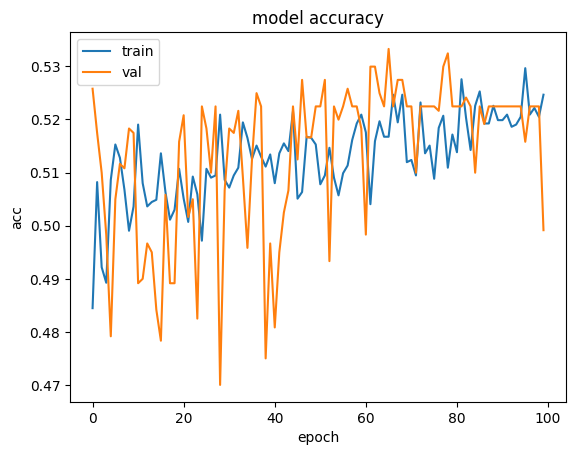

In [55]:
plot_history(control_history)

<h1>Data Exploration</h1>

In [56]:
import datetime as dt
dates = [dt.datetime.strptime(i[0], "%Y-%m-%d").date() for i in X[:,0,:]]

In [57]:
from collections import Counter
count_date = dict(Counter(dates))

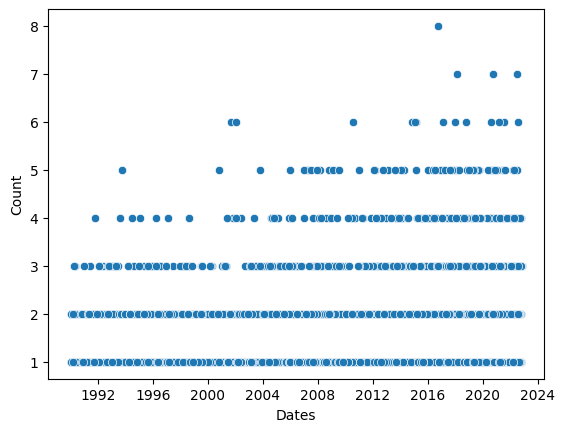

In [58]:
import seaborn as sns
ax = sns.scatterplot(x=count_date.keys(), y=count_date.values())
ax.set(xlabel='Dates', ylabel='Count')
plt.show()

The distribution of data is relatively even, Although it's skewed towards more recent dates.

<h1>Data Transformation</h1>

In [59]:
sample = X_train[0]

In [60]:
sample

array([[3.590850e+01, 1.950096e+08, 3.445640e+01, 1.639000e-01,
        7.583090e+01, 5.258000e-01],
       [3.613850e+01, 1.565216e+08, 3.472800e+01, 1.863000e-01,
        7.728230e+01, 6.881000e-01],
       [3.596720e+01, 1.032228e+08, 3.494700e+01, 2.037000e-01,
        7.373100e+01, 7.906000e-01],
       [3.627820e+01, 1.090204e+08, 3.518340e+01, 2.175000e-01,
        7.589660e+01, 8.831000e-01],
       [3.678490e+01, 1.301080e+08, 3.545970e+01, 2.436000e-01,
        7.894240e+01, 1.069900e+00],
       [3.669060e+01, 1.040388e+08, 3.569420e+01, 2.605000e-01,
        7.699250e+01, 1.178300e+00],
       [3.663640e+01, 8.019400e+07, 3.589510e+01, 2.570000e-01,
        7.583300e+01, 1.154800e+00],
       [3.540630e+01, 2.030708e+08, 3.590420e+01, 2.064000e-01,
        5.543100e+01, 9.596000e-01],
       [3.594600e+01, 1.342728e+08, 3.596940e+01, 1.628000e-01,
        6.045760e+01, 7.337000e-01],
       [3.606850e+01, 1.078432e+08, 3.602960e+01, 1.356000e-01,
        6.151850e+01, 6.283

In [61]:
from sklearn.preprocessing import MinMaxScaler

def scale_column(x, column = 1):
    """
    Doesn't mutate the original array
    """
    mms = MinMaxScaler()
    x2 = x.copy()
    # The volume column has index 1
    x2[:, 1] = mms.fit_transform(x2[:, column].reshape(14, 1)).reshape(14,)
    return x2

In [62]:
scale_column(sample)

array([[3.5908501e+01, 9.3620390e-01, 3.4456402e+01, 1.6390000e-01,
        7.5830902e+01, 5.2579999e-01],
       [3.6138500e+01, 6.3161093e-01, 3.4728001e+01, 1.8629999e-01,
        7.7282303e+01, 6.8809998e-01],
       [3.5967201e+01, 2.0980573e-01, 3.4946999e+01, 2.0370001e-01,
        7.3731003e+01, 7.9060000e-01],
       [3.6278198e+01, 2.5568777e-01, 3.5183399e+01, 2.1750000e-01,
        7.5896599e+01, 8.8309997e-01],
       [3.6784901e+01, 4.2257446e-01, 3.5459702e+01, 2.4360000e-01,
        7.8942398e+01, 1.0699000e+00],
       [3.6690601e+01, 2.1626353e-01, 3.5694199e+01, 2.6050001e-01,
        7.6992500e+01, 1.1783000e+00],
       [3.6636398e+01, 2.7556419e-02, 3.5895100e+01, 2.5700000e-01,
        7.5833000e+01, 1.1548001e+00],
       [3.5406300e+01, 9.9999994e-01, 3.5904202e+01, 2.0640001e-01,
        5.5431000e+01, 9.5959997e-01],
       [3.5945999e+01, 4.5553452e-01, 3.5969398e+01, 1.6280000e-01,
        6.0457600e+01, 7.3369998e-01],
       [3.6068501e+01, 2.4637145e-01,

In [63]:
check_rsi = lambda rsi: 0 if rsi is np.nan or (70 > rsi > 30) else (-1 if rsi < 30 else 1)
"""
Traditionally, RSI > 70 = Overbought, RSI < 30 Oversold
We transform the column to -1, 0, 1,
"""
vectorized_check_rsi = np.vectorize(check_rsi)

def rsi_transformer(x):
    x2 = x.copy()
    rsi_column = x2[:, 4]
    x2[:, 4] = vectorized_check_rsi(rsi_column)
    return x2

In [64]:
rsi_transformer(sample)

array([[3.590850e+01, 1.950096e+08, 3.445640e+01, 1.639000e-01,
        1.000000e+00, 5.258000e-01],
       [3.613850e+01, 1.565216e+08, 3.472800e+01, 1.863000e-01,
        1.000000e+00, 6.881000e-01],
       [3.596720e+01, 1.032228e+08, 3.494700e+01, 2.037000e-01,
        1.000000e+00, 7.906000e-01],
       [3.627820e+01, 1.090204e+08, 3.518340e+01, 2.175000e-01,
        1.000000e+00, 8.831000e-01],
       [3.678490e+01, 1.301080e+08, 3.545970e+01, 2.436000e-01,
        1.000000e+00, 1.069900e+00],
       [3.669060e+01, 1.040388e+08, 3.569420e+01, 2.605000e-01,
        1.000000e+00, 1.178300e+00],
       [3.663640e+01, 8.019400e+07, 3.589510e+01, 2.570000e-01,
        1.000000e+00, 1.154800e+00],
       [3.540630e+01, 2.030708e+08, 3.590420e+01, 2.064000e-01,
        0.000000e+00, 9.596000e-01],
       [3.594600e+01, 1.342728e+08, 3.596940e+01, 1.628000e-01,
        0.000000e+00, 7.337000e-01],
       [3.606850e+01, 1.078432e+08, 3.602960e+01, 1.356000e-01,
        0.000000e+00, 6.283

In [205]:
def pipeline(X):
    array = []
    for x in X:
        a = scale_column(x)
        b = rsi_transformer(a)
        array.append(a)
    return np.array(array)

In [172]:
X_train[3071][:, 1:4]

array([[7.388e-01, 3.600e+03, 7.701e-01],
       [7.203e-01, 1.200e+04, 7.629e-01],
       [8.127e-01, 4.800e+03, 7.683e-01],
       [7.019e-01, 1.320e+04, 7.587e-01],
       [7.019e-01, 2.400e+04, 7.502e-01],
       [7.388e-01, 3.480e+04, 7.471e-01],
       [6.649e-01, 6.240e+04, 7.349e-01],
       [6.280e-01, 3.840e+04, 7.186e-01],
       [6.095e-01, 2.760e+04, 7.008e-01],
       [6.464e-01, 8.880e+04, 6.904e-01],
       [6.834e-01, 1.320e+04, 6.859e-01],
       [6.649e-01, 2.100e+05, 6.793e-01],
       [6.095e-01, 1.920e+05, 6.672e-01],
       [6.095e-01, 3.720e+04, 6.566e-01]], dtype=float32)

In [206]:
X_train_final = pipeline(X_train)
X_dev_final = pipeline(X_dev)

In [350]:
NUM_OF_TIMESTEPS = 14
NUM_OF_FEATURES = 6


model = Sequential()
model.add(LSTM(32, stateful=False, dropout=0.7, input_shape=(NUM_OF_TIMESTEPS, NUM_OF_FEATURES), activation="relu", recurrent_dropout=0.7))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 32)                4992      
                                                                 
 dense_186 (Dense)           (None, 64)                2112      
                                                                 
 dense_187 (Dense)           (None, 32)                2080      
                                                                 
 dense_188 (Dense)           (None, 16)                528       
                                                                 
 dense_189 (Dense)           (None, 1)                 17        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [351]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [352]:
history = model.fit(X_train_final, y_class, epochs=30, verbose=1, batch_size=1)

In [353]:
plot_history(history)

6007/6007 [==============================] - 99s 16ms/step - loss: 0.6925 - acc: 0.5221
Epoch 5/30
6007/6007 [==============================] - 65s 11ms/step - loss: 0.6924 - acc: 0.5224
Epoch 6/30
6007/6007 [==============================] - 53s 9ms/step - loss: 0.6924 - acc: 0.5224
Epoch 7/30
6007/6007 [==============================] - 51s 8ms/step - loss: 0.6924 - acc: 0.5224
Epoch 8/30
1795/6007 [=======>......................] - ETA: 46s - loss: 0.6930 - acc: 0.5142

KeyboardInterrupt: 

In [355]:
model.evaluate(X_train_final, y_class)

188/188 [==============================] - 2s 5ms/step - loss: 0.6922 - acc: 0.5224


[0.6922318935394287, 0.5223905444145203]

In [354]:
control_model.evaluate(X_train_control, y_class)

188/188 [==============================] - 3s 5ms/step - loss: 0.6926 - acc: 0.5224


[0.6925849914550781, 0.5223905444145203]

In [356]:
model.evaluate(X_dev_final, y_dev_class)

21/21 [==============================] - 0s 5ms/step - loss: 0.6928 - acc: 0.5135


[0.6927947402000427, 0.5134730339050293]

In [357]:
control_model.evaluate(X_dev_control, y_dev_class)

21/21 [==============================] - 0s 5ms/step - loss: 0.6956 - acc: 0.5135


[0.6955590844154358, 0.5134730339050293]

Our more complex model didn't perform better than the benchmark model.
More data is needed including more technical indicators of different periods.

In [361]:
# model = Sequential()
# model.add(Input((NUM_OF_TIMESTEPS, NUM_OF_FEATURES, 1)))
# model.add(Conv2D(filters = 8, kernel_size=(1, NUM_OF_FEATURES),activation="relu"))
# model.add(Conv2D(filters = 8, kernel_size=(1, NUM_OF_FEATURES), activation="relu"))
# model.add(MaxPool2D(pool_size=(2, 1)))
# model.add(Conv2D(filters = 8, kernel_size=(3,1), activation="relu"))
# model.add(MaxPool2D(pool_size=(2,1)))
# model.add(Flatten())
# model.add(Dropout(0.1))
# model.add(Dense(2, activation="sigmoid"))
# model.summary()

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_38. Consider increasing the input size. Received input shape [None, 14, 1, 8] which would produce output shape with a zero or negative value in a dimension.